In [86]:
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

# Load in the dictionary dataset into a pandas df
data_path = os.path.join(os.getcwd(), 'data', 'dictionary.txt')
dic = pd.read_csv(data_path, sep='|', header=None)

# ...and do the same with the sentiment_labels data
data_path = os.path.join(os.getcwd(), 'data', 'sentiment_labels.txt')
cents = pd.read_csv(data_path, sep='|')

dic = dic.rename(columns={0: "feature", 1: "ID"})# We rename the columns
# dic = dic.rename(index={range(239232)})
dic = dic.sort_values(by="ID") # We change the order of the rows to be sorted by ID number
movie_data = dic[["ID", "feature"]] # We change the order of the columns and change the name of the the df

# We make an array of the sentiments (already in the right order) and add it to our df
y = np.array(cents.iloc[:, -1])
movie_data.insert(2, "sentiment", y)

phrase_data = movie_data.sort_index()
phrase_data.drop("ID",axis=1,inplace=True)
phrase_data.insert(2,"label",0)

print(phrase_data.head())

phrases = phrase_data

[nltk_data] Downloading package stopwords to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


       feature  sentiment  label
0            !    0.50000      0
1          ! '    0.52778      0
2         ! ''    0.50000      0
3       ! Alas    0.44444      0
4  ! Brilliant    0.86111      0


In [87]:
### add correct labels based on sentiment column (uses qualities of numpy for efficiency)

np_phrase = np.array(phrases) # make it a numpy array

# create a series of boolean masks
vpos = (0.8 < np_phrase[:, 1]).astype(int)
pos =  (0.6 < np_phrase[:, 1]).astype(int)
ntrl = (0.4 < np_phrase[:, 1]).astype(int)
neg = (0.2 < np_phrase[:, 1]).astype(int)
vneg = (0 <= np_phrase[:, 1]).astype(int)

# add the masks together to get the correct label numbers for each review based on sentiment value
h = vneg + neg + ntrl + pos + vpos - 1

# update the array with our new values
np_phrase[:, 2] = h

# change back to a pandas
phrases = pd.DataFrame(np_phrase)

In [88]:
# Feature importance

filler_words = set(stopwords.words('english'))
lemmatize = WordNetLemmatizer()

#values =[[0, 0.2], [0.2, 0.4], [0.4, 0.6], [0.6, 0.8], [0.8, 1.0]]
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
to_drop = []

phrases_list = list(phrases.iloc[:, 0])

for i in range(len(phrases_list)):
    # 'clean' phrases: remove numbers, punctuation and filler words
    phrase = phrases_list[i]
    phrase = re.sub(r'[^\w]', " ", phrase) #remove all special characters 
    cleaned = re.sub(r'[\d]', " ", phrase)  #remove all numbers

    if (cleaned.replace(" ","")==""):
        to_drop.append(i)
        cleaned=""
    else:
        cleaned = word_tokenize(cleaned.lower()) #tokenise for bag of words
        cleaned = [w for w in cleaned if w not in filler_words] # #remove all filler words
        cleaned = [lemmatize.lemmatize(word) for word in cleaned]
    
    phrases_list[i] = cleaned
    
phrases.iloc[:, 0] = phrases_list

# remove unnecessary data
phrases.drop(1,axis=1,inplace=True) 
phrases.drop(to_drop,axis=0,inplace=True)
df = phrases[~phrases.astype(str).duplicated()]
df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)
print(df.head())
print(df.shape)

#save this as file
df.to_pickle("clean_doc.pkl", protocol=4)

C:\Users\Will Boyd\AppData\Local\Temp\ipykernel_10328\1607633993.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("index",axis=1,inplace=True)


                                           0  2
0                                      [ala]  2
1                                [brilliant]  4
2                                   [c, mon]  2
3          [gollum, performance, incredible]  3
4  [oh, look, clever, angle, wow, jump, cut]  1
(149902, 2)


In [89]:
phrases = pd.read_pickle("clean_doc.pkl").iloc[:-1, :][0]

#create count array (sparse matrix)
vectorizer = CountVectorizer(max_features=8000)
vectorizerfit = vectorizer.fit_transform(phrases.astype(str))
names = vectorizer.get_feature_names_out()
count_array = vectorizerfit.toarray()
sparse = pd.DataFrame(data=count_array,columns=names)

# Transform to a TF-IDF encoding
TFIDF = sklearn.feature_extraction.text.TfidfTransformer()
phrases_TFIDF = TFIDF.fit_transform(sparse)

In [90]:
import pickle

with open('TF-IDF.txt', 'wb') as pickle_file:
    pickle.dump(phrases_TFIDF, pickle_file)
    pickle_file.close()

In [91]:
y_labels = pd.read_pickle("clean_rand_sample.pkl").iloc[:-1, :][2].astype(int)

with open('TF-IDF.txt', 'rb') as pickle_file:
    phrases_TFIDF = pickle.load(pickle_file)

In [92]:
#split test and train
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y_labels = y_labels.astype(int)

x_train, x_test, y_train, y_test = train_test_split(phrases_TFIDF, y_labels, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)

(104930, 8000) (44971, 8000) (104930,)


0.5943009625464596
0.5346334304329456


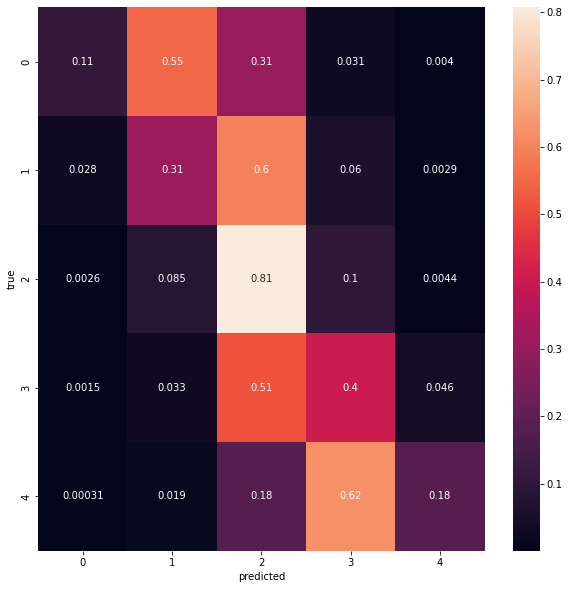

In [93]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
#log reg

clf = LogisticRegression(max_iter=10000)
clf.fit(x_train,y_train)
print(clf.score(x_train,y_train))
print(clf.score(x_test,y_test))

matrix = confusion_matrix(y_test,clf.predict(x_test), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 

ax.set_xticklabels([0, 1, 2, 3, 4]) # ordinal
ax.set_yticklabels([0, 1, 2, 3, 4]) # ordinal

# ax.set_xticklabels(["neg", "pos"]) # binary
# ax.set_yticklabels(["neg", "pos"]) # binary

ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("logreg_confused.png")
plt.show()